# Feature Engineering Checker
To guarantee the correctness of the feature engineering results used in modeling process, thie notebook aims at providing the verification. Furthermore, the exploration of new features is also implemented here. Code snippets related to EDA during the exploration will be moved to `eda.ipynb`.
<div class="alert alert-block alert-danger">
    <p>Feature engineering isn't constrained in the range of <strong>legitimate</strong> <code>shop_tag</code>s,
       others may also be helpful.
    </p> 
</div>

In [1]:
# Import packages
import os 
import pickle
from tqdm import tqdm_notebook as tqdm
import warnings
from joblib import Parallel, delayed
import gc

import yaml
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from paths import *
from metadata import *
from fe import *
from utils.dataset_generator import DataGenerator
from utils.grouper import FeatGrouper

# Configuration
pd.set_option('max_columns', 150)
warnings.simplefilter('ignore')

In [2]:
# Prepare data 
df = pd.read_parquet("./data/raw/raw_data.parquet", columns=PK+['txn_cnt', 'txn_amt'])
with open("./data/processed/purch_maps.pkl", 'rb') as f:
    purch_maps = pickle.load(f)
display(df.head(1))
print(f"Let's observe the purchasing map of client 10000000 \n{purch_maps[10000000]}")

,dt,chid,shop_tag,txn_cnt,txn_amt
0,1,10321418,45,3,3891.965283


Let's observe the purchasing map of client 10000000 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]


## *Purch Map*
### Time Since **First** Transaction of Each `shop_tag`

In [4]:
DTS_BASE = np.array([DTS]).T

In [5]:
# Check
def get_gap_since_first_txn(t_end, purch_map):
    '''Return time gap since first transaction of each shop_tag for a 
    single client.
    
    Zeros in the vector indicate that client has made his/her first 
    txn on that shop_tag at t_end. And one hundreds indicate that 
    client hasn't made a txn on that shop_tag so far.
    
    Parameters:
        t_end: int, the last time point taken into consideration when 
               generating X data
        purch_map: ndarray, purchasing behavior matrix, recording 0/1
                   indicating if transaction is made or not 
    
    Return:
        gap_vec: ndarray, vector including time gap since the first 
                 transaction of each shop_tag
    '''
    purch_map = purch_map[:t_end, :]
    purch_map = purch_map * DTS_BASE[:t_end]
    purch_map = np.where(purch_map == 0, 25, purch_map)
    gap_vec = np.min(purch_map, axis=0)
    gap_vec = t_end - gap_vec
    gap_vec = np.where(gap_vec < 0, 100, gap_vec)    
    gao_vec = gap_vec.astype(np.int8)
    
    return gap_vec

In [6]:
for chid, purch_map in tqdm(purch_maps.items()):
    get_gap_since_first_txn(t_end=24, purch_map=purch_map)

100%|██████████| 500000/500000 [00:07<00:00, 63495.64it/s]


### Time Since **Last** Transaction of Each `shop_tag`

In [7]:
# Check
def get_gap_since_last_txn(t_end, purch_map):
    '''Return time gap since last transaction of each shop_tag for a 
    single client.
    
    Zeros in the vector indicate that client has made a transaction at
    t_end. And one hundreds indicate that client hasn't made a txn on
    that shop_tag so far.
    
    Parameters:
        t_end: int, the last time point taken into consideration when 
               generating X data
        purch_map: ndarray, purchasing behavior matrix, recording 0/1
                   indicating if transaction is made or not 
    
    Return:
        gap_vec: ndarray, vector including time gap since last txn of  
                 each shop_tag
    '''
    purch_map = purch_map[:t_end, :]
    purch_map = purch_map * DTS_BASE[:t_end]
    purch_map = np.where(purch_map == 0, -100, purch_map)
    gap_vec = np.max(purch_map, axis=0)
    gap_vec = t_end - gap_vec
    gap_vec = np.where(gap_vec > 24, 100, gap_vec)    
    gao_vec = gap_vec.astype(np.int8)
    
    return gap_vec

In [8]:
for chid, purch_map in tqdm(purch_maps.items()):
    get_gap_since_last_txn(t_end=24, purch_map=purch_map)

100%|██████████| 500000/500000 [00:07<00:00, 63031.16it/s]


### Average Transaction Gap of Each `shop_tag`

In [9]:
# Check
def get_avg_txn_gap_vec(t_end, chid, purch_map):
    '''Return vector indicating average gap between transactions of 
    each shop_tag for a single client.
    *Note: Gap indicates the reciprocal of frequency.
    
    Time gap here is a little bit different from other two txn time gap
    features, gap_since_first and gap_since_last. Gap here indicates
    #months between two consecutive transactions.
    
    For example:
        dt  20  21  22  23  24
            V   X   X   X   V   ---->  time_gap == 3
            
    Parameters:
        t_end: int, the last time point taken into consideration when 
               generating X data
        chid: int, client identifier
        purch_map: ndarray, purchasing behavior matrix, recording 0/1
                   indicating if transaction is made or not 

    Return:
        chid: int, client identifier
        gap_vec: ndarray, average transaction gap of each shop_tag
    '''
    gap_vec = []
    purch_map = purch_map[:t_end, :]
    purch_map = purch_map * DTS_BASE[:t_end]
    for purch_vec in purch_map.T:
        # For purchasing vector of each shop_tag
        purch_vec_ = purch_vec[purch_vec != 0]
        avg_gap = np.mean(np.diff(purch_vec_, n=1) - 1)   # -1 to help interpret the concept 'gap'
        gap_vec.append(avg_gap)
    gap_vec = np.array(gap_vec)
    gap_vec = np.nan_to_num(gap_vec, nan=100)

    return chid, gap_vec

In [10]:
gap_vecs = Parallel(n_jobs=-1)(
    delayed(get_avg_txn_gap_vec)(24, chid, purch_map) 
    for chid, purch_map in tqdm(purch_maps.items())
)

100%|██████████| 500000/500000 [01:04<00:00, 7722.06it/s]


### Transaction State Toggles

In [11]:
# Check
def get_txn_st_tgl_mat(t_end, chid, purch_map):
    '''Return counts of transaction state toggles, including 0/0, 0/1,
    1/0, 1/1, total 4 state transitions.
    
    Parameters:
        t_end: int, the last time point taken into consideration when 
               generating X data
        chid: int, client identifier
        purch_map: ndarray, purchasing behavior matrix, recording 0/1
                   indicating if transaction is made or not 

    Return:
        chid: int, client identifier
        st_tgl_mat: ndarray, counts of state transitions, with shape 
                    (4, n_shop_tags)
    '''
    st_tgl_mat = []
    purch_map = purch_map[:t_end, :]
    for purch_vec in purch_map.T:
        # For purchasing vector of each shop_tag
        n_10 = abs(np.sum((purch_vec - 1)[1:] * purch_vec[:-1]))
        n_01 = abs(np.sum((purch_vec - 1)[:-1] * purch_vec[1:]))
        n_11 = abs(np.sum(purch_vec[:-1] * purch_vec[1:]))
        n_00 = (t_end-1) - n_10 - n_01 - n_11
        st_tgl_mat.append([n_00, n_01, n_10, n_11])
    st_tgl_mat = np.array(st_tgl_mat).T
    
    return chid, st_tgl_mat

In [12]:
st_tgl_mats = Parallel(n_jobs=-1)(
    delayed(get_txn_st_tgl_mat)(24, chid, purch_map) 
    for chid, purch_map in tqdm(purch_maps.items())
)

100%|██████████| 500000/500000 [01:04<00:00, 7746.05it/s]


### % of Months Each `shop_tag` Having Txn Records

In [17]:
# Check
def get_txn_made_ratio_vec(t_end, purch_map):
    '''Return ratio of months txn records exist for each shop_tag for 
    a single client.
    
    Parameters:
        t_end: int, the last time point taken into consideration when 
               generating X data
        purch_map: ndarray, purchasing behavior matrix, recording 0/1
                   indicating if transaction is made or not 

    Return:
        txn_made_ratio_vec: ndarray, ratio of months txn records exist
                            for each shop_tag
    '''
    purch_map = purch_map[:t_end, :]
    txn_made_ratio_vec = np.sum(purch_map, axis=0) / t_end
    
    return txn_made_ratio_vec

In [18]:
for chid, purch_map in tqdm(purch_maps.items()):
    get_txn_made_ratio_vec(t_end=24, purch_map=purch_map)

100%|██████████| 500000/500000 [00:04<00:00, 121896.73it/s]


### #`shop_tag`s Per Month 

In [2]:
# Check
def get_n_shop_tags_vec(t_end, purch_map, leg_only):
    '''Return number of shop_tags having txn records for six closest    
    months for a single client.
    
    Parameters:
        t_end: int, the last time point taken into consideration when 
               generating X data
        purch_map: ndarray, purchasing behavior matrix, recording 0/1
                   indicating if transaction is made or not 
        leg_only: bool, whether to consider legitimate shop_tags only 

    Return:
        n_shop_tags_vec: ndarray, num of shop_tags having txn records 
                         for each month
    '''
    purch_map = purch_map[:t_end, :]
    purch_map = purch_map[:, LEG_SHOP_TAGS_INDICES] if leg_only else purch_map
    n_shop_tags_vec = np.sum(purch_map, axis=1)
    
    
    return n_shop_tags_vec

In [14]:
for chid, purch_map in tqdm(purch_maps.items()):
    get_n_shop_tags_vec(24, purch_map, False)

100%|██████████| 500000/500000 [00:02<00:00, 177607.90it/s]


### Purchasing Vector of the Last Month

In [15]:
# Check
def get_purch_vec_t_end(t_end, purch_map):
    '''Directly return purchasing vector at t_end, the nearest purch
    behavior.
    
    Parameters:
        t_end: int, the last time point taken into consideration when 
               generating X data
        purch_map: ndarray, purchasing behavior matrix, recording 0/1
                   indicating if transaction is made or not 

    Return:
        purch_vec: ndarray, purchasing vector at t_end
    '''
    purch_vec = purch_map[t_end-1]   # -1 to align with index    
    
    return purch_vec

In [16]:
for chid, purch_map in tqdm(purch_maps.items()):
    get_purch_vec_t_end(t_end=24, purch_map=purch_map)

100%|██████████| 500000/500000 [00:00<00:00, 2371568.57it/s]


## *Single Feature Transformation*
### `slam`

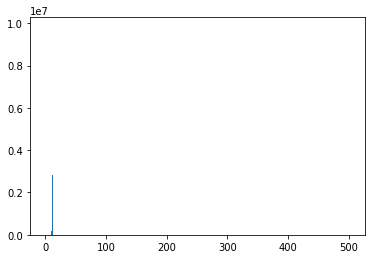

In [2]:
df = pd.read_parquet("./data/raw/raw_data.parquet", columns=PK+['slam'])
fig, ax  = plt.subplots()
ax.hist(x=np.log1p(df['slam']), bins=1500)
plt.show()

In [3]:
df['slam_log'] = np.log1p(df['slam'])
slam_log_stats = df.groupby('chid')['slam_log'].agg([np.nanmin, np.nanmax, np.nanmedian, np.nanmean, np.nanstd])
slam_log_stats['nanstd'].fillna(slam_log_stats['nanstd'].median(), inplace=True)
assert not pd.isna(slam_log_stats).any().any()
slam_stats = {}
for i, chid in tqdm(enumerate(slam_log_stats.index)):
    slam_stats[chid] = slam_log_stats.iloc[i].values
    
with open("./data/processed/slam_stats.pkl", 'wb') as f:
    pickle.dump(slam_stats,  f)

500000it [00:24, 20174.04it/s]


## *Feature Interaction Between Numeric Features*

In [7]:
# Prepare data
df = pd.read_parquet("./data/raw/raw_data.parquet")
df.drop([col for col in df.columns if 'pct' in col], axis=1, inplace=True)
df.head(1)

,dt,chid,shop_tag,txn_cnt,txn_amt,domestic_offline_cnt,domestic_online_cnt,overseas_offline_cnt,overseas_online_cnt,card_1_txn_cnt,card_2_txn_cnt,card_3_txn_cnt,card_4_txn_cnt,card_5_txn_cnt,card_6_txn_cnt,card_7_txn_cnt,card_8_txn_cnt,card_9_txn_cnt,card_10_txn_cnt,card_11_txn_cnt,card_12_txn_cnt,card_13_txn_cnt,card_14_txn_cnt,card_other_txn_cnt,masts,educd,trdtp,naty,poscd,cuorg,slam,gender_code,age,primary_card
0,1,10321418,45,3,3891.965283,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,4,5,1,99,30,95982.822967,1,4,1


In [8]:
# Replace pct columns with corresponing txn_amt representation 
df_ = pd.read_parquet("./data/raw/raw_txn_amts.parquet", columns=['domestic_offline_txn_amt']) #PCT2AMTS)
df_.replace(to_replace=0, value=1025.89962, inplace=True)
df = pd.concat([df, df_], axis=1)
print(f"Shape of the concatenated DataFrane {df.shape}")
del df_
gc.collect()
df.head()

Shape of the concatenated DataFrane (32975653, 35)


,dt,chid,shop_tag,txn_cnt,txn_amt,domestic_offline_cnt,domestic_online_cnt,overseas_offline_cnt,overseas_online_cnt,card_1_txn_cnt,card_2_txn_cnt,card_3_txn_cnt,card_4_txn_cnt,card_5_txn_cnt,card_6_txn_cnt,card_7_txn_cnt,card_8_txn_cnt,card_9_txn_cnt,card_10_txn_cnt,card_11_txn_cnt,card_12_txn_cnt,card_13_txn_cnt,card_14_txn_cnt,card_other_txn_cnt,masts,educd,trdtp,naty,poscd,cuorg,slam,gender_code,age,primary_card,domestic_offline_txn_amt
0,1,10321418,45,3,3891.965283,3,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,4,5,1,99,30,95982.822967,1,4,1,3891.965283
1,1,10414574,15,2,10616.561549,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,2,15,1,2,30,130702.351368,1,3,1,10616.561549
2,1,10134567,48,2,23527.655416,0,2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,11,1,3,30,112010.611717,0,4,1,1025.899620
3,1,10001003,48,9,17751.558260,7,2,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,11,1,2,30,59701.507360,0,3,1,13313.668695
4,1,10267183,2,1,21701.307598,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,6,15,1,99,30,0.000000,0,6,0,21701.307598


### `txn_amt` Per `txn_cnt`
Interpret `txn_amt` from perspective of **on average** and discretize transaction states, which are illustrated as follows:
> 0: Transaction amount is not zero but transaction count is **zero**.<br>
> 1: Total transaction amount less than pseudo imputed zero transaction amount.<br>
> 2: Total transaction amount equal than pseudo imputed zero transaction amount.<br>
> 3: Total transaction amount greater than pseudo imputed zero transaction amount.

In [2]:
def get_txn_amt_per_cnt(df, feat_amt, feat_cnt):
    '''Get transaction amount per transaction count, which can indicate
    transaction behavior from the perspective of "on average".
    
    Parameters:
        df: pd.DataFrame, raw data
        feat_amt: str, transaction amount feature name
        feat_cnt: str, transaction count feature name
    
    Return:
        df_amt_per_cnt: pd.DataFrame, containing amount per count and 
                        discrete states.
    '''
    feat_amt_per_cnt = f'{feat_amt}_per_cnt'
    df_ = df[[feat_amt, feat_cnt]]
    df_[feat_amt_per_cnt] = df_[feat_amt] / df_[feat_cnt]
    
    # Post-process and discretize amount per count to discrete states 
    df_.replace([np.inf, -np.inf], np.nan, inplace=True)
    states = np.where(df_[feat_amt] > imputation, 3, df_[feat_amt])
    states = np.where(df_[feat_amt] == imputation, 2, states)
    states = np.where(df_[feat_amt] < imputation, 1, states)
    nan_entries = df_[pd.isna(df_[feat_amt_per_cnt])].index
    states[nan_entries] = 0
    df_[f'{feat_amt_per_cnt}_state'] = states.astype(np.int8)
    
    return df_[[feat_amt_per_cnt, f'{feat_amt_per_cnt}_state']]

In [3]:
imputation = 1025.89962

df = pd.DataFrame()
for feat_amt in tqdm(['txn_amt']+PCT2AMTS):
    df_ = pd.DataFrame()
    feat_cnt = feat_amt.replace('txn_amt', 'cnt')
    if feat_amt == 'txn_amt':
        df_[feat_amt] = pd.read_parquet(DATA_PATH_RAW, columns=[feat_amt])
        df_[feat_cnt] = pd.read_parquet(DATA_PATH_RAW, columns=['txn_cnt'])
    else:
        df_[feat_amt] = pd.read_parquet(DATA_PATH_TXN_AMTS, columns=[feat_amt])
        df_[feat_cnt] = pd.read_parquet(DATA_PATH_RAW, columns=[feat_cnt])
    df_.replace({feat_amt: 0}, imputation, inplace=True)
    df_processed = get_txn_amt_per_cnt(df_, feat_amt, feat_cnt)
#     print(f"Feature combination {feat_amt} + {feat_cnt}...")
#     display(df_processed.iloc[:, -1].value_counts())
    df = pd.concat([df, df_processed], axis=1)
    del df_, df_processed
df.to_parquet("./data/raw/raw_amt_cnt.parquet", index=False)

100%|██████████| 20/20 [01:11<00:00,  3.56s/it]


## Groupby Stats

In [2]:
# Prepare data 
# imputation = 797.165663
feats_test = ['txn_cnt', 'txn_amt']
df = pd.read_parquet(DATA_PATH_RAW, columns=PK+CLI_ATTRS[1:]+feats_test)
# df.replace({'txn_amt': 0}, imputation, inplace=True)
df.head()

,dt,chid,shop_tag,masts,educd,trdtp,naty,poscd,cuorg,gender_code,age,txn_cnt,txn_amt
0,1,10321418,45,1,4,5,1,99,30,1,4,3,3891.965283
1,1,10414574,15,2,2,15,1,2,30,1,3,2,10616.561549
2,1,10134567,48,1,3,11,1,3,30,0,4,2,23527.655416
3,1,10001003,48,2,3,11,1,2,30,0,3,9,17751.558260
4,1,10267183,2,2,6,15,1,99,30,0,6,1,21701.307598


In [3]:
# Synthetic configuration
cfg_test = []
#     [['txn_cnt', 'txn_amt', 'card_4_txn_txn_amt', 'c2_txn_apc'], {'cli_attrs': ['masts', 'educd'], 'apc_states': ['c1_txn_apc_state']}, [i for i in range(16, 23)], [2, 6, 10], ['mean', 'nanquantile_0.4']],
#     [['txn_cnt', 'txn_amt'], ['trdtp', 'naty'], [22, 21, 20, 19, 18, 17], [36, 37], ['std']],
#     [['shop_tag'], ['chid'], [i for i in range(17, 23)], [], ['count']]
for cli_attr in ['masts']:
    cfg_test.append([['txn_amt'], 
                     {'cli_attrs': [cli_attr], 'apc_states': []}, 
                     (6, 0), 
                     'leg', 
                     ['mean', 'nanquantile_0.25', 'nanquantile_0.5', 'nanquantile_0.75', 'nanquantile_0.9']])
# Run groupby and agg
fg = FeatGrouper(t_end=22)
a = []
for cfg in cfg_test:
    feats, keys, time_slots, shop_tags, stats = cfg
    df_agg = fg.groupby_and_agg(keys, time_slots, shop_tags, feats, stats)
    a.append(df_agg)
    del df_agg

### Post Processing for Feature Prediction Matrix
Because I design a new feature engineering process supporting feature vectors generated with different parameter sets, these features can form a **matrix** which I can use to derive **stats** and choose the specified feature vectors.